In [1]:
import ssl

# Отключаем проверку SSL-сертификатов
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('https://docs.google.com/spreadsheets/d/твой айди/export?format=csv')

# Выводим первые строки для проверки
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515260 entries, 0 to 515259
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             515260 non-null  int64  
 1   preset_id      388744 non-null  float64
 2   input_tokens   515260 non-null  int64  
 3   output_tokens  515260 non-null  int64  
 4   inserted_at    515260 non-null  object 
 5   updated_at     515260 non-null  object 
 6   user_id        515260 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 27.5+ MB


In [5]:
import pandas as pd

# Предполагаем, что у вас есть DataFrame df
# Группируем по preset_id и выполняем агрегацию
df_grouped = df.groupby('preset_id').agg(
    count_request=('id', 'size'),  # Считаем количество запросов (по id, так как это уникальный идентификатор запроса)
    total_input_tokens=('input_tokens', 'sum'),  # Суммируем input_tokens
    total_output_tokens=('output_tokens', 'sum'),  # Суммируем output_tokens
    unique_user_count=('user_id', 'nunique')  # Считаем количество уникальных user_id
).reset_index()


      preset_id  count_request  total_input_tokens  total_output_tokens  \
0           1.0            111                3607                 3781   
1           2.0             85                8874                 6791   
2           3.0            275               13096                 8707   
3           4.0          51750            10234867              2576099   
4           5.0              5                 262                  439   
...         ...            ...                 ...                  ...   
3461     5818.0              2                1338                  268   
3462     5820.0              2                2620                   79   
3463     5822.0              4                1502                  467   
3464     5823.0              5                1048                  781   
3465     5825.0              1                 814                  320   

      unique_user_count  
0                     3  
1                     3  
2                    

In [6]:
# Выводим результат
df_grouped

,preset_id,count_request,total_input_tokens,total_output_tokens,unique_user_count
0,1.0,111,3607,3781,3
1,2.0,85,8874,6791,3
2,3.0,275,13096,8707,5
3,4.0,51750,10234867,2576099,2326
4,5.0,5,262,439,1
...,...,...,...,...,...
3461,5818.0,2,1338,268,1
3462,5820.0,2,2620,79,1
3463,5822.0,4,1502,467,1
3464,5823.0,5,1048,781,1


In [9]:
# Сохранение в pickle и CSV
df_grouped_requests = df_grouped

df_grouped_requests.to_pickle("df_grouped_requests.pkl")
df_grouped_requests.to_csv("df_grouped_requests.csv", index=False)

In [10]:
df_grouped_requests['preset_id'].nunique()

3466

In [11]:
# Оставляем нужные столбцы и преобразуем даты (только день)
df_d_filtered = df[['id', 'inserted_at']].copy()
df_d_filtered['inserted_at'] = pd.to_datetime(df_d_filtered['inserted_at']).dt.date

# Группировка сделок по дате создания
df_d_grouped = df_d_filtered.groupby('inserted_at').agg(Requests_Count=('id', 'count')).reset_index()

# Приводим 'inserted_at' к datetime
df_d_grouped['inserted_at'] = pd.to_datetime(df_d_grouped['inserted_at'], errors='coerce')

# Переименовываем inserted_at в Date (чтобы использовать в графиках)
df_d_grouped = df_d_grouped.rename(columns={'inserted_at': 'Date'})

# Заполняем пропуски
df_d_grouped.fillna(0, inplace=True)

# Используем отфильтрованные данные
merged_data = df_d_grouped.copy()

# Перемещаем колонку Date на нулевую позицию
cols = ['Date'] + [col for col in merged_data.columns if col != 'Date']
merged_data = merged_data[cols]

# Выводим обновленный DataFrame
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 544 entries, 0 to 543
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            544 non-null    datetime64[ns]
 1   Requests_Count  544 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 8.6 KB


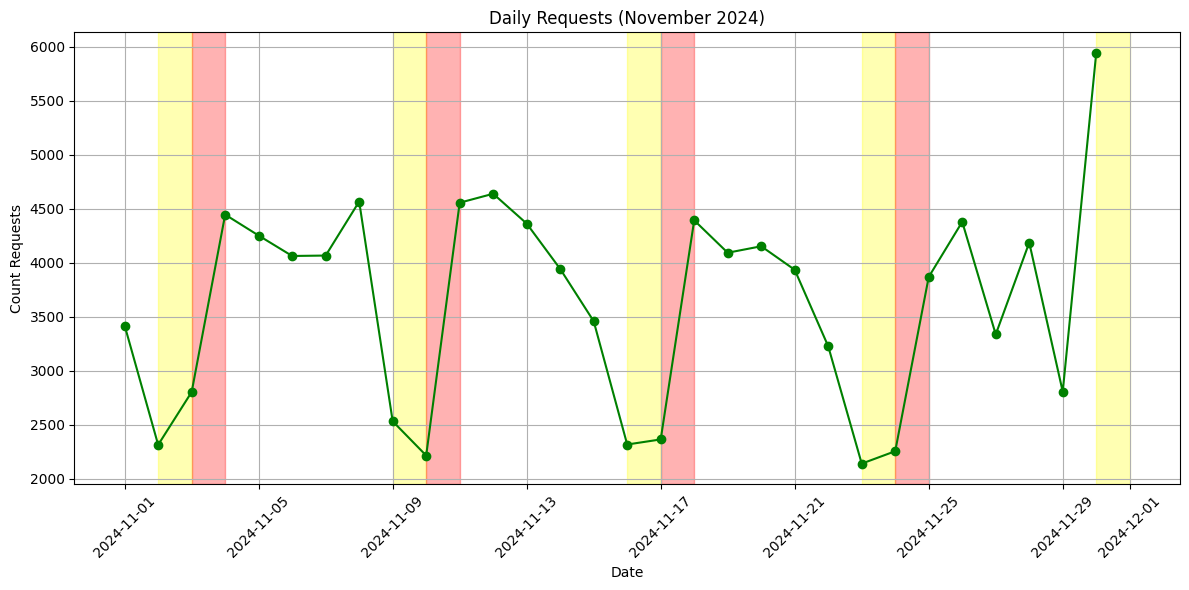

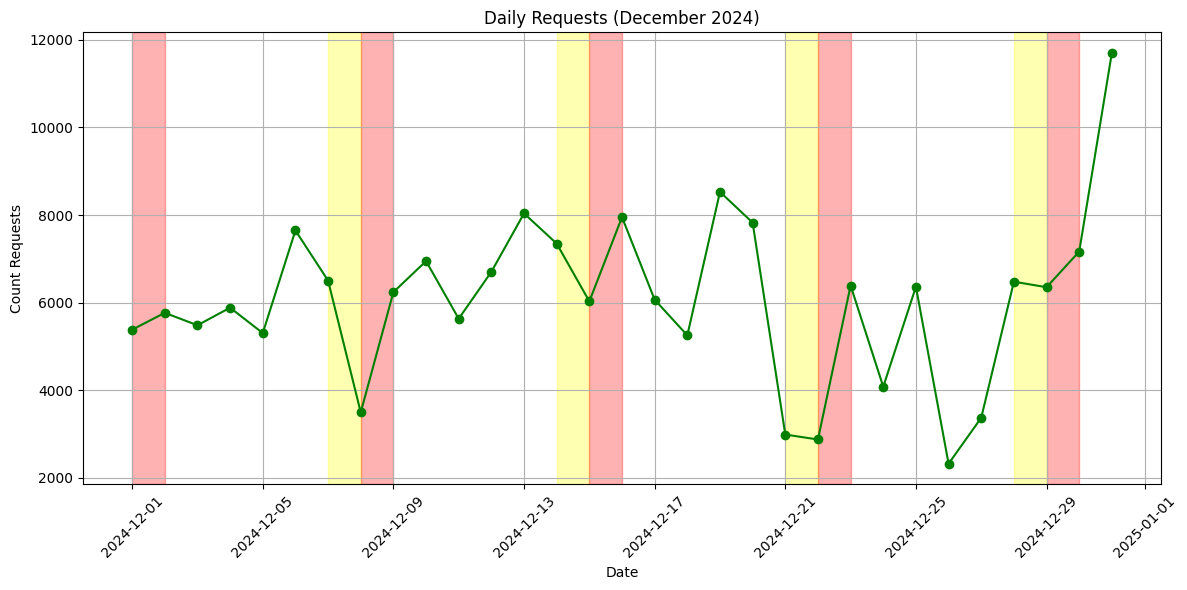

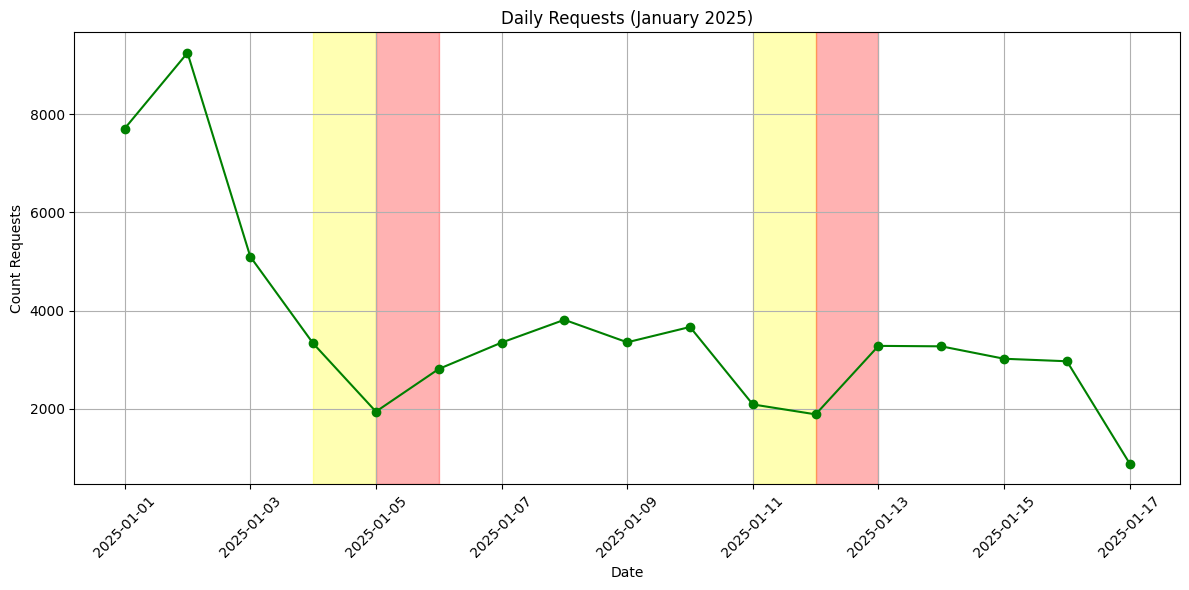

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Определяем цвета для выходных
weekend_colors = {5: 'yellow', 6: 'red'}  # 5 - суббота, 6 - воскресенье

# Фильтруем данные по месяцам
months = {
    "November 2024": ('2024-11-01', '2024-11-30'),
    "December 2024": ('2024-12-01', '2024-12-31'),
    "January 2025": ('2025-01-01', '2025-01-31')
}

for month, (start_date, end_date) in months.items():
    filtered_data = merged_data[(merged_data['Date'] >= start_date) & (merged_data['Date'] <= end_date)]
    df_daily_filtered = filtered_data.resample('D', on='Date').sum()

    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Основной график
    ax.plot(df_daily_filtered.index, df_daily_filtered['Requests_Count'], marker='o', linestyle='-', color='g', label='Requests')

    # Добавляем выделение выходных дней
    for date in df_daily_filtered.index:
        day_of_week = date.weekday()
        if day_of_week in weekend_colors:
            ax.axvspan(date, date + pd.Timedelta(days=1), color=weekend_colors[day_of_week], alpha=0.3)

    # Настройки графика
    ax.set_xlabel('Date')
    ax.set_ylabel('Count Requests', color='black')
    ax.tick_params(axis='y', labelcolor='black')
    ax.grid(True)
    plt.title(f'Daily Requests ({month})')
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Сохраняем перед plt.show()
    plt.savefig(f"daily_requests_{month.replace(' ', '_')}.png", dpi=300, bbox_inches='tight')

    # Отображаем график
    plt.show()

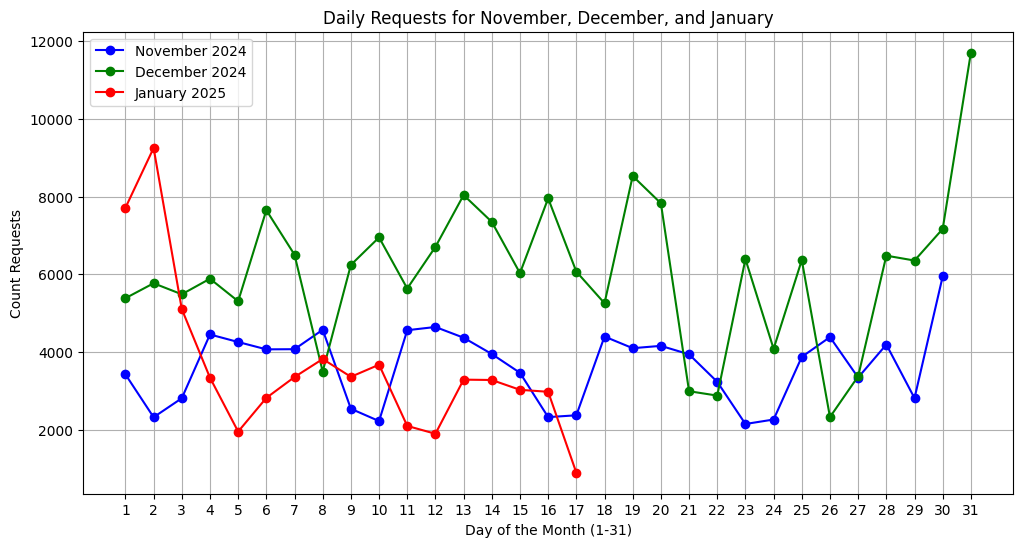

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Определяем цвета для месяцев
month_colors = {"November 2024": "blue", "December 2024": "green", "January 2025": "red"}

# Фильтруем данные по месяцам
months = {
    "November 2024": ('2024-11-01', '2024-11-30'),
    "December 2024": ('2024-12-01', '2024-12-31'),
    "January 2025": ('2025-01-01', '2025-01-31')
}

# Создаем график
fig, ax = plt.subplots(figsize=(12, 6))

for month, (start_date, end_date) in months.items():
    filtered_data = merged_data[(merged_data['Date'] >= start_date) & (merged_data['Date'] <= end_date)].copy()

    # Группируем по дню месяца
    df_daily_filtered = filtered_data.groupby(filtered_data['Date'].dt.day)['Requests_Count'].sum()

    # Строим график
    ax.plot(df_daily_filtered.index, df_daily_filtered.values, marker='o', linestyle='-', color=month_colors[month], label=month)

# Настройки осей
ax.set_xlabel('Day of the Month (1-31)')
ax.set_ylabel('Count Requests', color='black')
ax.grid(True)
ax.legend()
plt.title('Daily Requests for November, December, and January')
plt.xticks(range(1, 32))  # Ось X с днями 1-31

# Сохраняем график в файл
plt.savefig("daily_requests_nov_dec_jan.png", dpi=300, bbox_inches='tight')

# Отображаем график
plt.show()